In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar
from tqdm import tqdm

from qsa_pwfa.simulation import Simulation
from qsa_pwfa.external_fields import GaussianBeam
from qsa_pwfa.species import NeutralUniformPlasma
from qsa_pwfa.species import GaussianBunch
from qsa_pwfa.species import NeutralNoneUniformPlasma
from qsa_pwfa.diagnostics import FieldDiagnostics

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
# Beam
n_b = 16.
R_b = 0.25
ksi0 = 5.
R_xi = 1.

# plasma
L_xi = 18.
L_r = 10.

# grid
N_xi = 512 * 8
N_r = 512

d_xi = L_xi / N_xi
dr = L_r / N_r

Q_tot = n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12
print(Q_tot)

1197.4784654024647


In [6]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi)
sim.add_specie( NeutralUniformPlasma(L_r=L_r, N_r=N_r) )
sim.add_specie( GaussianBunch( n_b, R_b, R_xi, ksi0, 256, sim, q=1 ) )

sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r, N_r=N_r,
                      fields=['dPsi_dxi','Density','J_z'], 
                      xi_step=4,
                      ),
    ]

#sim.add_external_field(GaussianBeam(n_b, R_b, ksi0, R_xi))
sim.run(iter_max=40, rel_err_max=1e-2, mixing_factor=0.07, track_convergence=True)

100%|██████████| 4095/4095 [00:24<00:00, 167.71it/s]


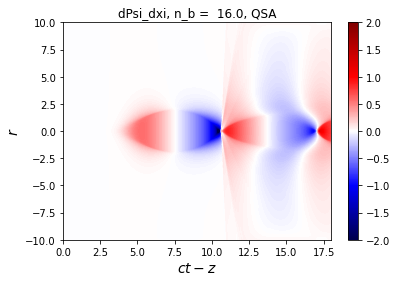

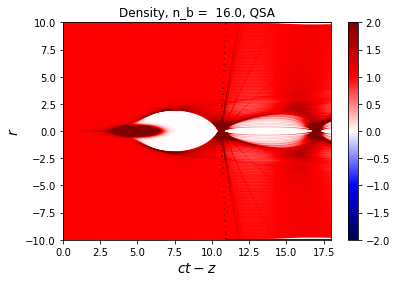

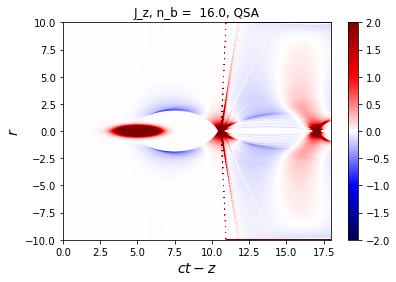

In [7]:
for diag in sim.diagnostics:
    ext = np.array([diag.xi.min(), 
                    diag.xi.max(),
                   -diag.grid.L_r, 
                    diag.grid.L_r ]) 
    
    for fld in diag.fields: 
        val = diag.Data[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

        plt.figure(figsize=(6,4))

        vmax = 2
        plt.imshow(val_ext.T,
                   origin='lower',
                   aspect='auto',
                   cmap=plt.cm.seismic,
                   vmax=vmax,
                   vmin=-vmax,
                   extent=ext
                  )

        plt.colorbar()
        plt.xlabel(r'$ct-z$', fontsize=14)
        plt.ylabel(r'$r$', fontsize=14)

        plt.title(f"{fld}, n_b =  {n_b}, QSA")

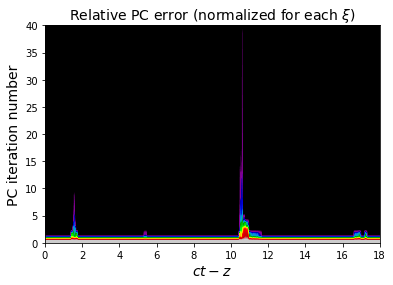

In [8]:
N_xi_err = len(sim.err_rel_list)
iter_max = 40
ext = [0, L_xi, 0, iter_max] 

error_map = np.zeros( (iter_max, N_xi_err) )

for ixi in range(N_xi_err):
    err_rel_loc = sim.err_rel_list[ixi]
    error_map[:len(err_rel_loc), ixi] = err_rel_loc

plt.figure()

plt.imshow(error_map / error_map.max(0)[None, :], 
           origin='lower', aspect='auto', 
           extent=ext, cmap=plt.cm.nipy_spectral)

plt.xlabel(r'$ct-z$', fontsize=14)
plt.ylabel(r'PC iteration number', fontsize=14)
plt.title(r'Relative PC error (normalized for each $\xi$)', fontsize=14);